In [56]:
import pandas as pd

# Get train data
train = pd.read_excel("startup_train.xlsx")
train.describe()

,Unnamed: 0,latitude,longitude,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500
count,848.000000,848.000000,848.000000,848.000000,848.000000,702.000000,702.000000,848.000000,848.000000,8.480000e+02,...,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000
mean,571.002358,38.504824,-103.564257,2.223177,3.894685,3.048329,4.755572,7.676887,2.298349,2.579623e+07,...,0.002358,0.318396,0.317217,0.261792,0.508255,0.389151,0.225236,0.097877,2.797364,0.803066
std,333.576073,3.706122,22.144918,2.523640,2.991336,2.979745,3.252957,7.306696,1.387887,1.977265e+08,...,0.048536,0.466129,0.465667,0.439870,0.500227,0.487845,0.417984,0.297324,1.854596,0.397917
min,1.000000,25.752358,-122.756956,-9.046600,-9.046600,-14.169900,-3.882200,0.000000,1.000000,1.100000e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,281.750000,37.388869,-122.202789,0.552075,1.643850,1.000000,2.337675,3.000000,1.000000,2.600000e+06,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.383325,1.000000
50%,572.500000,37.779281,-118.388216,1.449350,3.469850,2.504100,4.426050,5.000000,2.000000,1.000000e+07,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.333300,1.000000
75%,865.250000,40.730646,-77.225989,3.516425,5.495875,4.658900,6.753400,10.000000,3.000000,2.430000e+07,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.666700,1.000000
max,1153.000000,54.983201,-1.574631,21.895900,21.895900,24.684900,24.684900,63.000000,10.000000,5.700000e+09,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,1.000000


In [57]:
# Data preprocessing
import numpy as np
train['age_first_milestone_year'].fillna(3.048329, inplace=True)
train['age_last_milestone_year'].fillna(4.755572, inplace=True)

def time_trans(name):
    time1 = pd.to_datetime(train[name],format = '%m/%d/%Y')
    time2 = (time1.values - np.datetime64('1970-01-01T08:00:00Z')) / np.timedelta64(1, 'ms')
    return time2

train['founded_at'] = time_trans('founded_at')
train['first_funding_at'] = time_trans('first_funding_at')
train['last_funding_at'] = time_trans('last_funding_at')

train.loc[train['status']=='closed','status']=0
train.loc[train['status']=='acquired','status']=1
train['status'] = train['status'].astype('int')

<ipython-input-57-70968e4a9314>:8: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  time2 = (time1.values - np.datetime64('1970-01-01T08:00:00Z')) / np.timedelta64(1, 'ms')


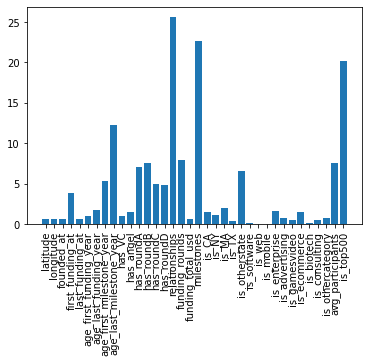

In [58]:
# Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt

select = ['latitude','longitude','founded_at','first_funding_at','last_funding_at',
          'age_first_funding_year','age_last_funding_year','age_first_milestone_year','age_last_milestone_year',
          'has_VC','has_angel','has_roundA','has_roundB','has_roundC','has_roundD',
          'relationships','funding_rounds','funding_total_usd','milestones',
          'is_CA','is_NY','is_MA','is_TX','is_otherstate',
          'is_software','is_web','is_mobile','is_enterprise','is_advertising','is_gamesvideo',
          'is_ecommerce','is_biotech','is_consulting','is_othercategory',
          'avg_participants','is_top500']

selector=SelectKBest(f_classif,k=2)
selector.fit(train[select],train['status'])
scores=-np.log10(selector.pvalues_)

plt.bar(range(len(select)), scores)
plt.xticks(range(len(select)), select, rotation='vertical')
plt.show()

In [67]:
# Train Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

predictors = ['relationships','milestones','is_top500','age_last_milestone_year','funding_rounds','avg_participants']
X_train, X_test, Y_train, Y_test = train_test_split(train[predictors], train['status'], test_size = 0.25, random_state = 42)
model = RandomForestClassifier(max_depth=5, min_samples_split=2, n_estimators=150, random_state=6).fit(X_train, Y_train) # Accuracy: 0.8160377358490566
# model = DecisionTreeClassifier(max_depth=5, min_samples_split=2, random_state=6).fit(X_train, Y_train) # Accuracy: 0.7688679245283019
# model = ExtraTreesClassifier(max_depth=5, min_samples_split=2,n_estimators=150, random_state=6).fit(X_train, Y_train) # Accuracy: 0.7216981132075472
Y_pred = model.predict(X_test)

print ('Accuracy:', accuracy_score(Y_test, Y_pred))

Classifier:  ExtraTreesClassifier ,  Accuracy: 0.7216981132075472


In [60]:
# Test data
test = pd.read_excel("startup_test_new.xlsx")
test.describe()

# Test data preprocessing
test['age_first_milestone_year'].fillna(3.126814, inplace=True)
test['age_last_milestone_year'].fillna(4.742733, inplace=True)

test[predictors].describe()
test_pre = model.predict(test[predictors])
test_pre = np.array(test_pre)

In [61]:
# Write .csv file
import csv

with open("result.csv","w",encoding="utf-8",newline="") as f:
    writer = csv.writer(f)
    writer.writerow(['ID', 'status'])
    for i,j in zip(test_pre,range(len(test_pre))):
        if i==1:
            writer.writerow(np.array([j+1,'acquired']))
        else:
            writer.writerow(np.array([j+1,'closed']))
